In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Load dataset coba di jadiin 20-30%
df = pd.read_csv("/content/drive/My Drive/datacredit.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800000 entries, 0 to 4799999
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 549.3+ MB


In [ ]:
df [df['Is Fraud?'] == 'Yes'].shape

(5933, 15)

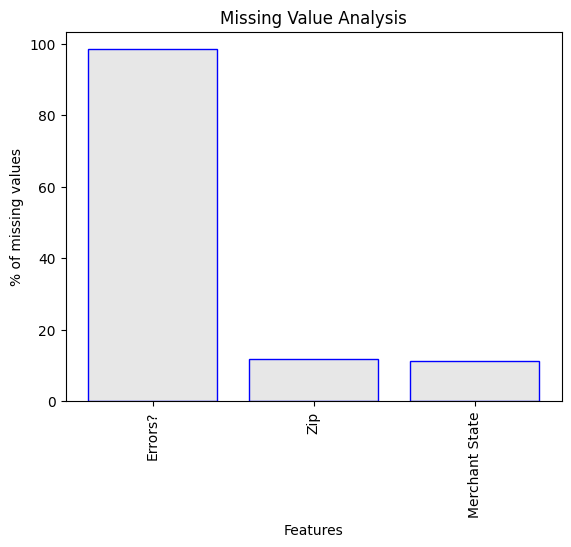

In [ ]:
# Identify columns with missing values
cols_with_missing = df.columns[df.isnull().any()]

# Filter DataFrame to only include columns with missing values
df_filtered = df[cols_with_missing]

# Calculate percentage of missing values for each column
percent_missing = (df_filtered.isnull().sum() * 100 / df_filtered.shape[0]).sort_values(ascending=False)

# Create the plot (if there are columns with missing values)
if len(percent_missing) > 0:
  plt.title("Missing Value Analysis")
  plt.xlabel("Features")
  plt.ylabel("% of missing values")
  plt.bar(percent_missing.index, percent_missing, color=(0.1, 0.1, 0.1, 0.1), edgecolor='blue')
  # Use plt.xticks to display column names with rotation
  plt.xticks(rotation=90)
  plt.show()
else:
  print("No columns with missing values found!")

In [ ]:
df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)

In [ ]:
df.Amount.head(5)

0      $59.18
1     $280.91
2    $-144.00
3       $6.76
4       $9.17
Name: Amount, dtype: object

In [ ]:
# We need to strip the ‘$’ from the Amount to cast as a float
df["Amount"]=df["Amount"].str.replace("$","").astype(float)

In [ ]:
# time can't be casted to int so so opted to extract the hour and minute
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]

In [ ]:
df.Hour

0          00
1          22
2          07
3          14
4          11
           ..
4799995    12
4799996    08
4799997    20
4799998    16
4799999    12
Name: Hour, Length: 4800000, dtype: object

In [ ]:
df.Minute

0          11
1          12
2          07
3          58
4          44
           ..
4799995    40
4799996    36
4799997    39
4799998    45
4799999    51
Name: Minute, Length: 4800000, dtype: object

In [ ]:
df = df.drop(["Time","User","Card"],axis=1)

In [ ]:
df["Errors?"].unique()

array([nan, 'Bad PIN', 'Insufficient Balance', 'Technical Glitch',
       'Bad Card Number', 'Bad CVV', 'Bad Expiration', 'Bad Zipcode',
       'Insufficient Balance,Technical Glitch', 'Bad Card Number,Bad CVV',
       'Bad CVV,Insufficient Balance',
       'Bad Card Number,Insufficient Balance', 'Bad PIN,Technical Glitch',
       'Bad PIN,Insufficient Balance', 'Bad Card Number,Bad Expiration',
       'Bad Expiration,Bad CVV', 'Bad Expiration,Insufficient Balance',
       'Bad Zipcode,Insufficient Balance', 'Bad CVV,Technical Glitch',
       'Bad Expiration,Technical Glitch',
       'Bad Card Number,Technical Glitch'], dtype=object)

In [ ]:
df["Errors?"]= df["Errors?"].fillna("No error")

In [ ]:
df = df.drop(columns=["Merchant State","Zip"],axis=1)

In [ ]:
# change the is fraud column to binary
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
df["Merchant City"]=LabelEncoder().fit_transform(df["Merchant City"])
df["Use Chip"]=LabelEncoder().fit_transform(df["Use Chip"])
df["Errors?"]=LabelEncoder().fit_transform(df["Errors?"])

In [ ]:
df["Errors?"].unique()

array([19, 12, 17, 20,  3,  0,  8, 15, 18,  4,  1,  6, 14, 13,  5,  9, 10,
       16,  2, 11,  7])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800000 entries, 0 to 4799999
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Year           int64  
 1   Month          int64  
 2   Day            int64  
 3   Amount         float64
 4   Use Chip       int64  
 5   Merchant Name  int64  
 6   Merchant City  int64  
 7   MCC            int64  
 8   Errors?        int64  
 9   Is Fraud?      int64  
 10  card_id        object 
 11  Hour           object 
 12  Minute         object 
dtypes: float64(1), int64(9), object(3)
memory usage: 476.1+ MB


In [ ]:
df.head()

,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,MCC,Errors?,Is Fraud?,card_id,Hour,Minute
0,2019,7,10,59.18,0,-6853385250336487907,4581,5813,19,0,1470_0,00,11
1,2019,1,14,280.91,1,4241336128694185533,7811,4814,19,0,822_1,22,12
2,2010,3,15,-144.00,2,190253443608377572,4681,3359,19,0,41_3,07,07
3,2015,9,20,6.76,0,-7837310524365334241,6081,5300,19,0,1084_0,14,58
4,2014,10,12,9.17,2,-5023497618971072366,3946,5812,19,0,1384_0,11,44


In [ ]:
# Create an empty graph
G = nx.MultiGraph()

# Add nodes to the graph for each unique card_id, merchant_name
G.add_nodes_from(df["card_id"].unique(), type='card_id')
G.add_nodes_from(df["Merchant Name"].unique(), type='merchant_name')

In [ ]:
# Add edges and properties to the edges
for _, row in df.iterrows():
    # Create a variable for each properties for each edge

        year = row["Year"],
        month = row["Month"],
        day = row["Day"],
        hour = row["Hour"],
        minute =row["Minute"],
        amount = row["Amount"],
        use_chip =  row["Use Chip"],
        merchant_city = row["Merchant City"],
        errors =  row["Errors?"],
        mcc = row['MCC']


        G.add_edge(row['card_id'], row['Merchant Name'], year = year , month = month , day = day ,
              hour = hour , minute = minute , amount = amount , use_chip = use_chip ,
              merchant_city = merchant_city , errors = errors , mcc = mcc)



In [ ]:
# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the number of nodes and edges
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 67024
Number of edges: 4800000


In [ ]:
# Convert the graph to an adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

In [ ]:
adj_matrix.shape

(67024, 67024)

In [ ]:
# Get a small sample of the nodes in the graph
sample_nodes = list(G.nodes())[:10]

# Retrieve the properties of the sample nodes
node_properties = nx.get_node_attributes(G, 'type')

# Print the properties of the sample nodes
for node in sample_nodes:
    print(f"Node: {node}, Properties: {node_properties[node]}")


Node: 1470_0, Properties: card_id
Node: 822_1, Properties: card_id
Node: 41_3, Properties: card_id
Node: 1084_0, Properties: card_id
Node: 1384_0, Properties: card_id
Node: 55_3, Properties: card_id
Node: 776_0, Properties: card_id
Node: 66_0, Properties: card_id
Node: 1880_2, Properties: card_id
Node: 490_5, Properties: card_id


In [ ]:
sample_size = 5
for i, edge in enumerate(G.edges()):
    print(G.get_edge_data(*edge))
    if i >= sample_size - 1:
        break

{0: {'year': (2019,), 'month': (7,), 'day': (10,), 'hour': ('00',), 'minute': ('11',), 'amount': (59.18,), 'use_chip': (0,), 'merchant_city': (4581,), 'errors': (19,), 'mcc': 5813}, 1: {'year': (2019,), 'month': (10,), 'day': (1,), 'hour': ('00',), 'minute': ('22',), 'amount': (91.4,), 'use_chip': (0,), 'merchant_city': (4581,), 'errors': (19,), 'mcc': 5813}, 2: {'year': (2011,), 'month': (9,), 'day': (27,), 'hour': ('00',), 'minute': ('00',), 'amount': (64.21,), 'use_chip': (2,), 'merchant_city': (4581,), 'errors': (19,), 'mcc': 5813}, 3: {'year': (2011,), 'month': (11,), 'day': (11,), 'hour': ('00',), 'minute': ('04',), 'amount': (64.36,), 'use_chip': (2,), 'merchant_city': (4581,), 'errors': (19,), 'mcc': 5813}, 4: {'year': (2009,), 'month': (11,), 'day': (25,), 'hour': ('00',), 'minute': ('18',), 'amount': (52.75,), 'use_chip': (2,), 'merchant_city': (4581,), 'errors': (19,), 'mcc': 5813}, 5: {'year': (2013,), 'month': (5,), 'day': (20,), 'hour': ('00',), 'minute': ('21',), 'amount

In [ ]:
# Retrieve the properties errors of all the edges
edge_properties = nx.get_edge_attributes(G, 'errors')

# Count the number of edges by property value
edge_count_by_property = Counter(edge_properties.values())

# Print the count of edges by property value
for property_value, count in edge_count_by_property.items():
    print(f"Property value: {property_value}, Count: {count}")


Property value: (19,), Count: 4723579
Property value: (12,), Count: 11601
Property value: (20,), Count: 9317
Property value: (17,), Count: 47915
Property value: (0,), Count: 2112
Property value: (8,), Count: 2132
Property value: (18,), Count: 81
Property value: (3,), Count: 2609
Property value: (15,), Count: 412
Property value: (13,), Count: 120
Property value: (10,), Count: 11
Property value: (4,), Count: 9
Property value: (14,), Count: 22
Property value: (5,), Count: 10
Property value: (9,), Count: 11
Property value: (1,), Count: 16
Property value: (6,), Count: 28
Property value: (16,), Count: 2
Property value: (2,), Count: 3
Property value: (7,), Count: 3
Property value: (11,), Count: 7


In [ ]:
# Prepare the data for input into the model
edge_list = list(G.edges(data=True))

In [ ]:
list(edge_list[i][2].values())

[(2009,), (11,), (25,), ('00',), ('18',), (52.75,), (2,), (4581,), (19,), 5813]

We define a PyTorch neural network model called "FraudGNN" which is a type of Graph Neural Network. The model is a simple feedforward neural network with two fully connected (Linear) layers. The first layer has input_dim number of input units and hidden_dim number of output units, while the second layer has hidden_dim number of input units and 1 output unit. The forward function of the model applies the linear layers to the input tensor "x" and applies a ReLU activation function to the output of the first linear layer.

In [ ]:
class FraudGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FraudGNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x.squeeze(-1)

# Prepare the data for input into the model
edge_list = list(G.edges(data=True))
x = []
for edge in edge_list:
    edge_values = list(edge[2].values())
    edge_values = [float(i[0]) if type(i) == tuple and type(i[0]) == str else i[0] if type(i) == tuple else i for i in edge_values]
    x.append(edge_values)
x = torch.tensor(x, dtype=torch.float)

In [ ]:
target = torch.tensor(df['Is Fraud?'].values, dtype=torch.float)

In [ ]:
# Prepare data for training and testing
X_train, X_test, y_train, y_test = train_test_split(x, target, test_size=0.3, random_state=41)

In [ ]:
# Define the model
input_dim = len(x[0])
hidden_dim = 16
model = FraudGNN(input_dim, hidden_dim)
num_epochs= 101

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Define lists to store training loss and accuracy
train_losses = []
train_accuracies = []

In [ ]:
# Train the model
for i in range(num_epochs):
  # Forward pass
  output = model(X_train)
  # Compute the loss
  loss = criterion(output, y_train)
  train_losses.append(loss.item())  # Append loss value

  # Calculate accuracy
  with torch.no_grad():
    predictions = (torch.sigmoid(output) > 0.5).float()
    accuracy = (predictions == y_train).sum() / len(y_train)
    train_accuracies.append(accuracy.item())  # Append accuracy value

  # Print loss and accuracy every 5 epochs
  #if i % 5 == 0:
  print(f'Epoch: {i}, Loss: {loss.item()}, Accuracy: {accuracy:.4f}')

  # Zero the gradients
  optimizer.zero_grad()
  # Perform backpropagation
  loss.backward()
  # Update the parameters
  optimizer.step()

# Evaluate model on test data (optional)
with torch.no_grad():
  test_output = model(X_test)
  test_predictions = (torch.sigmoid(test_output) > 0.5).float()
  test_accuracy = (test_predictions == y_test).sum() / len(y_test)
  print(f"\nTest Accuracy: {test_accuracy:.4f}")

Epoch: 0, Loss: 1.6130108833312988, Accuracy: 0.9988
Epoch: 1, Loss: 1.5744656324386597, Accuracy: 0.9988
Epoch: 2, Loss: 1.536002516746521, Accuracy: 0.9988
Epoch: 3, Loss: 1.497628092765808, Accuracy: 0.9988
Epoch: 4, Loss: 1.4593467712402344, Accuracy: 0.9988
Epoch: 5, Loss: 1.4211640357971191, Accuracy: 0.9988
Epoch: 6, Loss: 1.3830738067626953, Accuracy: 0.9988
Epoch: 7, Loss: 1.3450736999511719, Accuracy: 0.9988
Epoch: 8, Loss: 1.3071606159210205, Accuracy: 0.9988
Epoch: 9, Loss: 1.2693222761154175, Accuracy: 0.9988
Epoch: 10, Loss: 1.2315534353256226, Accuracy: 0.9988
Epoch: 11, Loss: 1.193851351737976, Accuracy: 0.9988
Epoch: 12, Loss: 1.1562036275863647, Accuracy: 0.9988
Epoch: 13, Loss: 1.1186068058013916, Accuracy: 0.9988
Epoch: 14, Loss: 1.0810527801513672, Accuracy: 0.9988
Epoch: 15, Loss: 1.043524980545044, Accuracy: 0.9988
Epoch: 16, Loss: 1.0060120820999146, Accuracy: 0.9988
Epoch: 17, Loss: 0.9685060977935791, Accuracy: 0.9988
Epoch: 18, Loss: 0.9309987425804138, Accur

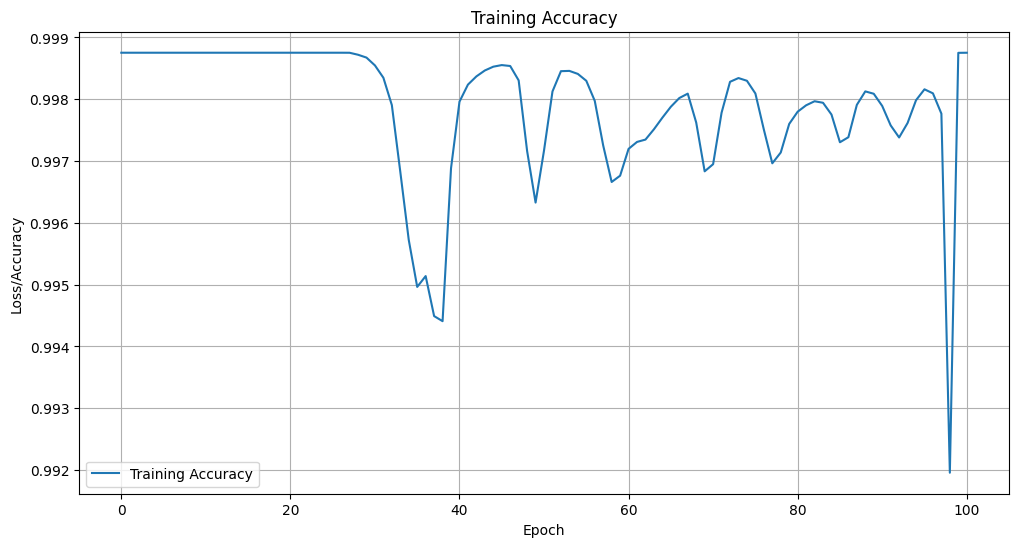

In [ ]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 6))

#plt.plot(train_losses, label='Training Loss')
plt.plot(train_accuracies, label='Training Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()

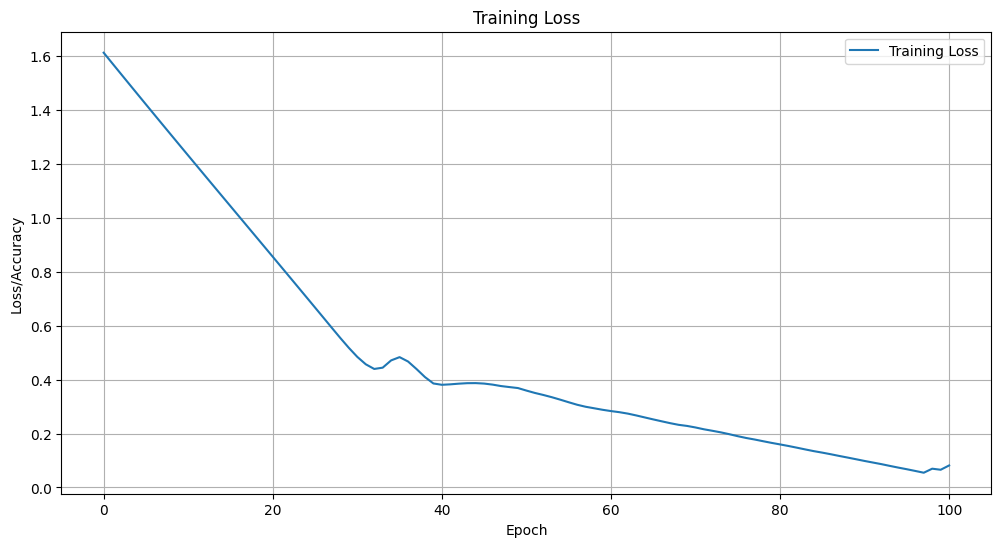

In [ ]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 6))

plt.plot(train_losses, label='Training Loss')
#plt.plot(train_accuracies, label='Training Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import torch.nn as nn

# Assuming `model` is your FraudGNN model
# Extract the weights of the linear layer
for name, param in model.named_parameters():
    if 'weight' in name:
        weights = param.data
        break

# Calculate feature importance
feature_importance = torch.abs(weights).sum(dim=0)  # Assuming the features are in columns

# Get the index of the most important feature
most_important_feature_idx = torch.argmax(feature_importance).item()

# Print the most important feature
print(f"The most important feature is feature {most_important_feature_idx}.")


The most important feature is feature 5.


In [ ]:
# Define the list of feature names
feature_names = [
    "Year",
    "Month",
    "Day",
    "Amount",
    "Use Chip",
    "Merchant Name",
    "Merchant City",
    "MCC",
    "Errors?",
    "Is Fraud?",
    "card_id",
    "Hour",
    "Minute"
]


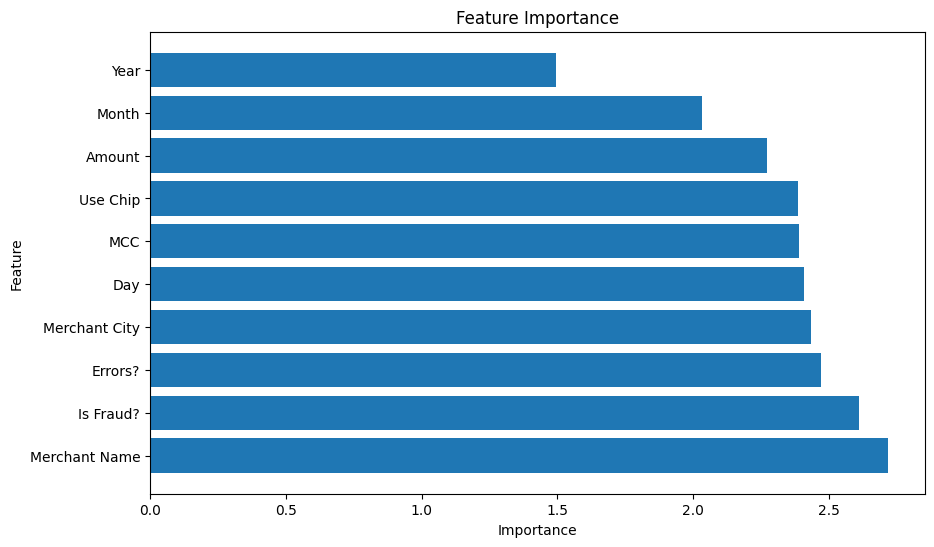

In [ ]:
import matplotlib.pyplot as plt

# Assuming `model` is your FraudGNN model
# Extract the weights of the linear layer
for name, param in model.named_parameters():
    if 'weight' in name:
        weights = param.data
        break

# Assuming `feature_names` is a list containing the names of the features
# Calculate feature importance
feature_importance = torch.abs(weights).sum(dim=0).cpu().detach().numpy()  # Assuming the features are in columns

# Get the indices that would sort the feature importance in descending order
sorted_indices = feature_importance.argsort()[::-1]

# Sort the feature importance values and their corresponding indices
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.yticks(range(len(sorted_feature_importance)), sorted_feature_names)
plt.title('Feature Importance')
plt.show()


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
def visualize_graph(model, features, G):
    # Assuming `model` is your FraudGNN model
    # Assuming `features` contains the node features

    # Assuming `model` has a `forward` method that takes features and returns node embeddings
    with torch.no_grad():
        embeddings = model(features)

    # Create a graph
    # G = nx.Graph()  # We are not creating a new graph here

    # Add nodes and embeddings
    num_nodes = embeddings.shape[0]
    for i, node in enumerate(G.nodes()):
        G.nodes[node]['embedding'] = embeddings[i].tolist()

    # Add edges based on connectivity between nodes (for demonstration purposes, randomly adding some edges)
    edges = [(random.choice(list(G.nodes())), random.choice(list(G.nodes()))) for _ in range(50)]
    G.add_edges_from(edges)

    # Visualize the graph
    pos = nx.spring_layout(G)  # You may change layout based on your preference
    nx.draw_networkx_nodes(G, pos, node_color='b', alpha=0.5, node_size=100)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.axis('off')
    plt.show()


In [ ]:
# Visualize the graph after training
visualize_graph(model, x, G)  # Assuming G is your original graph